This notebook is used to prepare a critical difference plot and a Pareto frontier analysis plot.


In [1]:
cd ..

/Users/rcap/Projects/benchmark-join-suggestions


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import polars as pl
import matplotlib.pyplot as plt
import scikit_posthocs as sp
from src.utils.logging import read_and_process
from src.utils import plotting, constants
from src.utils.critical_difference_plot import critical_difference_diagram
import numpy as np
import seaborn as sns

sns.set_context("talk")
plt.style.use("seaborn-v0_8-talk")


In [4]:
def prepare_general():
    result_path = "stats/overall/overall_first.parquet"

    # Use the standard method for reading all results for consistency.
    df_results = pl.read_parquet(result_path)
    current_results = read_and_process(df_results)
    others = [
        col
        for col in current_results.columns
        if col not in constants.GROUPING_KEYS + ["case"]
    ]
    current_results = current_results.group_by(constants.GROUPING_KEYS + ["case"]).agg(
        pl.mean(others)
    )
    current_results = current_results.filter(pl.col("estimator") != "nojoin")
    _d = current_results.filter(
        (pl.col("estimator") != "top_k_full_join")
        # & (pl.col("jd_method") != "starmie")
        & (~pl.col("target_dl").is_in(["open_data_us", "wordnet_vldb_50"]))
        # & (~pl.col("base_table").is_in(["movies", "movies_vote"]))
    )
    return _d


df = prepare_general()

In [5]:
keys = ["jd_method", "estimator", "aggregation", "chosen_model"]
exp_keys = ["base_table", "target_dl"]
names = df.unique(keys).select(keys).sort(keys).with_row_index("model")
df = df.join(names, on=keys, how="left")
experiments = (
    df.unique(exp_keys).select(exp_keys).sort(exp_keys).with_row_index("experiment")
)
df = df.join(experiments, on=exp_keys, how="left")

In [6]:
names

model,jd_method,estimator,aggregation,chosen_model
u32,str,str,str,str
0,"""exact_matching…","""best_single_jo…","""first""","""catboost"""
1,"""exact_matching…","""best_single_jo…","""first""","""linear"""
2,"""exact_matching…","""full_join""","""first""","""catboost"""
3,"""exact_matching…","""full_join""","""first""","""linear"""
4,"""exact_matching…","""highest_contai…","""first""","""catboost"""
5,"""exact_matching…","""highest_contai…","""first""","""linear"""
6,"""exact_matching…","""stepwise_greed…","""first""","""catboost"""
7,"""exact_matching…","""stepwise_greed…","""first""","""linear"""
8,"""minhash""","""best_single_jo…","""first""","""catboost"""


In [7]:
ranks = (
    df.group_by(["experiment", "model"])
    .agg(pl.mean("y"))
    .with_columns(
        pl.col("y").rank("ordinal", descending=True).over(["experiment"]).alias("rank")
    )
    .select("model", "rank")
)

In [8]:
rank_by_model = (
    df.group_by(["experiment", "model"])
    .agg(pl.mean("y"))
    .with_columns(
        pl.col("y").rank("ordinal", descending=True).over(["experiment"]).alias("rank")
    )
    .group_by("model")
    .agg(
        rank_median=pl.median("rank"),
        rank_mean=pl.mean("rank"),
    )
)

In [9]:
df_avg = df.group_by(keys).agg(pl.mean("y")).sort(keys).with_row_index(name="model")
p_values = sp.posthoc_conover(df.to_pandas(), val_col="y", group_col="model")

In [10]:
n = (
    names.with_columns(
        prepared_name=pl.col("jd_method")
        + "-"
        + pl.col("estimator")
        + "-"
        + pl.col("aggregation")
        + "-"
        + pl.col("chosen_model")
    ).select(pl.col("model", "prepared_name"))
)

In [11]:
this_d = (
    ranks.group_by("model")
    .agg(pl.mean("rank"))
    .join(n, on="model")
    .select(["prepared_name", "rank"])   
    # .with_columns(rank=-pl.col("rank"))
)
dd = dict(zip(*this_d.to_dict().values()))

In [12]:
colors = {
    "exact_matching": "green",
    "minhash_hybrid": "orange",
    "minhash": "red",
    "starmie": "blue",
}
color_props = {k: colors[k.split("-")[0]] for k in dd}

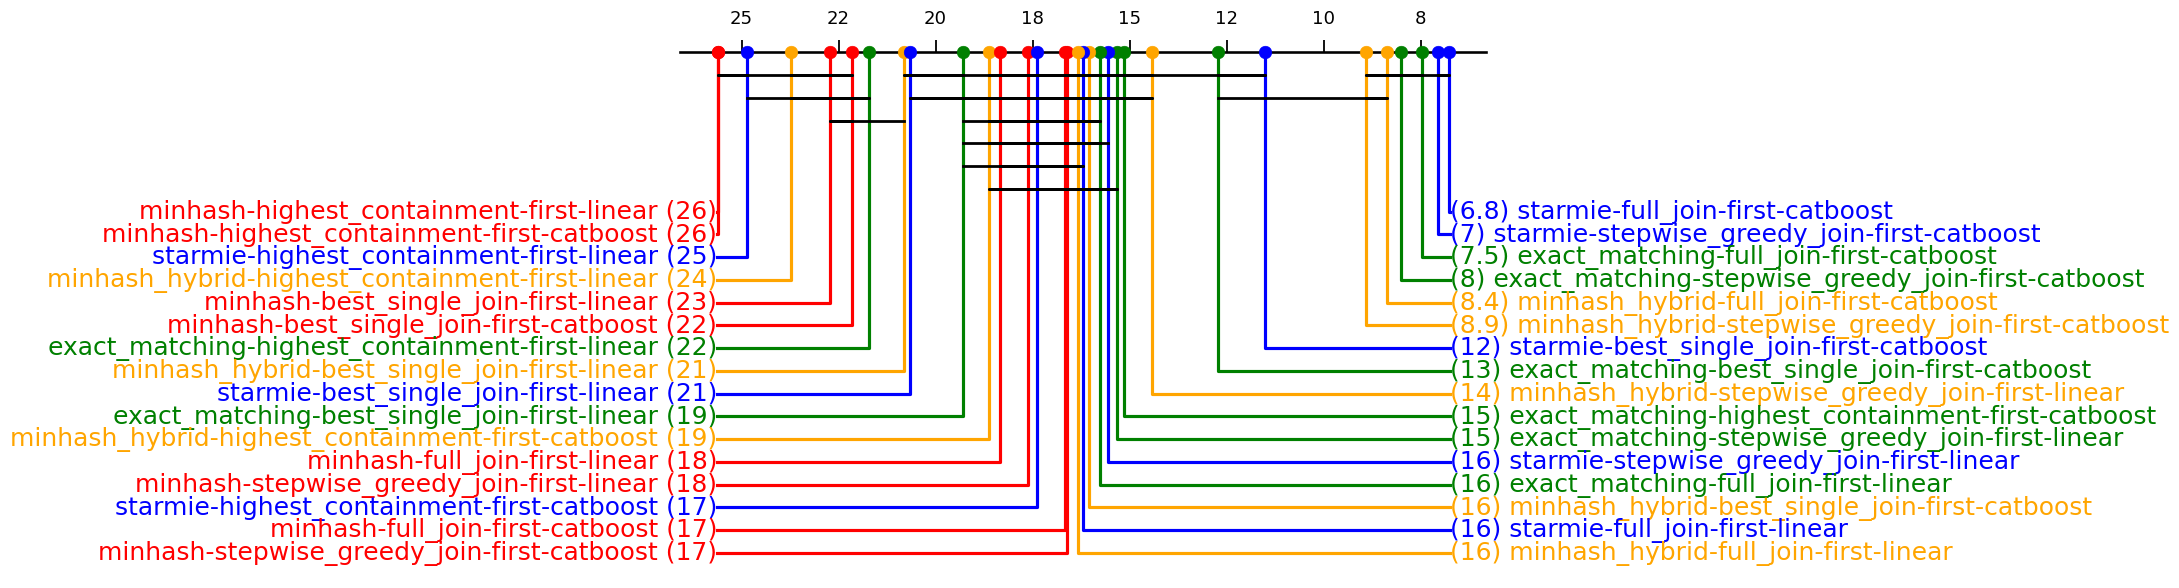

In [13]:
_ = critical_difference_diagram(dd, p_values, color_palette=color_props, ascending=False)
plt.savefig("images/crit_diff_plot.png")
plt.savefig("images/crit_diff_plot.pdf")

## Pareto front


In [14]:
res = df.group_by(keys).agg(pl.mean("time_run"), pl.mean("y"))
res = res.with_columns(time_run_scaled = pl.col("time_run")/pl.col("time_run").max())
res = res.with_columns(err_y = 1-pl.col("y"))
x = res["err_y"]
y = res["time_run_scaled"]

In [15]:
hues = {0: "estimator", 1: "chosen_model", 2: "jd_method"}
titles = {0: "Selector", 1: "Prediction Model", 2: "Retrieval method"}
hue_order = {
    0: ["full_join","highest_containment", "stepwise_greedy_join", "best_single_join"],
    1: ["catboost", "linear"],
    2: ["exact_matching", "starmie", "minhash","minhash_hybrid"],
    }
palettes = {0: "tab10", 1: "tab10", 2: "tab10"}

(3.9046352558785613, 343.55865193833245)
(3.865105333505502, 425.40517976269)
(3.824029551828235, 532.4082192016343)


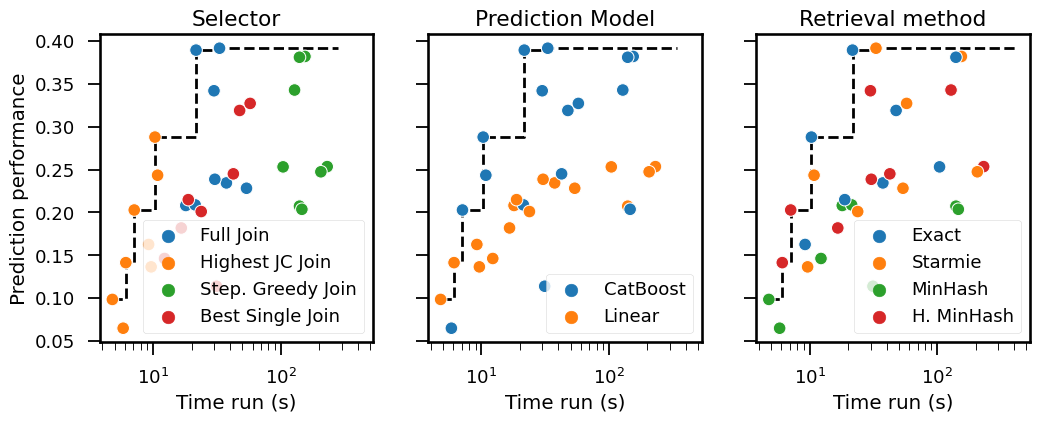

In [16]:
x = res["time_run"]
y = res["y"]

fig, axs = plt.subplots(1, 3, squeeze=True, sharey=True,sharex=True, figsize=(12,4))

axs[0].set_xscale("log")
axs[0].set_ylabel("Prediction performance")
xs = np.array(x)
ys = np.array(y)
perm = np.argsort(xs)
xs = xs[perm]
ys = ys[perm]

for idx, ax in enumerate(axs):
    sns.scatterplot(data=res.to_pandas(), x="time_run", y="y", hue=hues[idx], ax=ax, 
                    palette=palettes[idx], hue_order=hue_order[idx], 
                    )

    xs_pareto = [xs[0], xs[0]]
    ys_pareto = [ys[0], ys[0]]
    for i in range(1, len(xs)):
        if ys[i] > ys_pareto[-1]:
            xs_pareto.append(xs[i])
            ys_pareto.append(ys_pareto[-1])
            xs_pareto.append(xs[i])
            ys_pareto.append(ys[i])
    xs_pareto.append(ax.get_xlim()[1])
    ys_pareto.append(ys_pareto[-1])

    ax.plot(xs_pareto, ys_pareto, "--", color="k", linewidth=2, zorder=0.8)

    print(ax.get_xlim())
    ax.set_title(titles[idx])
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, [constants.LABEL_MAPPING[hues[idx]][_] for _ in l ], title=None, )
    ax.set_xlabel("Time run (s)")

fig.savefig("images/pareto_frontier.pdf")
fig.savefig("images/pareto_frontier.png")